# Lab Assignment Five: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa

# Business Case

This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a young person would have an interest in PC Software and Hardware. According to Time Magazine (http://time.com/4433964/teens-social-media-advertising/), "YouTube has become so saturated with popular vloggers that marketers are now turning to so-called "micro-influencers" with smaller but more devoted followings, while agencies are shifting their ad dollars from television to YouTube."

What is a "micro-influencer"? "A micro-influencer is usually Instafamous or a Youtube sensation with a relatively high social following who they have a great impact on." (https://www.bcsagency.com/news/step-aside-bloggers-its-time-for-micro-influencers-to-take-the-stage) According to Digiday (http://digiday.com/marketing/micro-influencers/), if a content creator with a large audience promotes a product, there is a chance that only a small subset of their audience is interested. A "micro-influencer" would likely have an audience that we mostly interested in a product placement by their trusted "micro-influencer".

PC Software and Hardware is the classifier that we chose for this project, but there are various other interests in our dataset (Socializing, Dancing, Art) that could be predicted. The point is to gauge interest in a particular topic, hire a "micro-influencer" to generate content for that topic, and include product placement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from scipy.special import expit
import time
import math
from memory_profiler import memory_usage
from sklearn import metrics as mt


from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target_classifier = 'PC'
df = pd.read_csv('responses.csv', sep=",")

# Preparation

In [2]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [3]:
df_cleaned_classifier.isnull().sum().max()

20

In [4]:
df_fixed.shape

(1004, 173)

Our dataset (1010 rows and 150 columns) was mostly ordinal data as numbers (preferences ranked 1-5) . We also had some ordinal data as strings. 

e.g.
How much time do you spend online?: No time at all - Less than an hour a day - Few hours a day - Most of the day

We first removed any rows which contained NaN values for our target classifer, Shopping centres. Afterwards we imputed mean values for any NaN values in other features. We decided to impute due to the fact that there were not many NaN values in our features compared to the size of our data set. (At most was 20 for a feature, as shown above). We then one-hot encoded any string object, which created extra features.

We are left with numerical values for our features and a size of 1007 x 172

# Evaluation

## Metrics To Evaluate Algorithm's Generalization Performance

In [5]:
# Research on Cost Matrix
# http://www.ibm.com/support/knowledgecenter/SSEPGG_11.1.0/com.ibm.im.model.doc/c_cost_matrix.html

cost_matrix = np.matrix([[0,1,2,3,4],
[1,0,1,2,3],
[3,1,0,1,2],
[5,3,1,0,1],
[7,5,2,1,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

confusion_scorer = make_scorer(get_confusion_costTot, greater_is_better=False)
confusion_scorer

make_scorer(get_confusion_costTot, greater_is_better=False)

## Divide Data into Training and Testing

In [6]:
from sklearn.model_selection import StratifiedKFold

# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the label we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

X = X/5
num_folds = 10

cv_object = StratifiedKFold(n_splits= num_folds, random_state=None, shuffle=True)
cv_object.split(X,y)

print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


We are using Stratified K Fold as our cross-validation object. Scikit's page states "each set contains approximately the same percentage of samples of each target class as the complete set."(http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) This is important as we want to represent the dataset as accurately as possible. Kfolds also includes all our data over the course of the folds, so we know that all our data is being used at some point.

We did not split our data into validation/train/test sets due to the fact that our data sample size is small (just over 1000 samples). We kept our data set split into training and test. 

# Modeling

## Custom Implementation of Multi-Layer Perceptron

In [7]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, nonlinearity = "sigmoid"):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.nonlinearity = nonlinearity
        self.params = {}
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if(self.nonlinearity == "sigmoid"):
            A2 = self._sigmoid(Z1)
            A2 = self._add_bias_unit(A2, how='row')
            Z2 = W2 @ A2
            A3 = self._sigmoid(Z2)
        else:
            A2 = Z1
            A2 = self._add_bias_unit(A2, how='row')
            Z2 = W2 @ A2
            A3 = Z2
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        if(self.nonlinearity == "sigmoid"):
            sigma3 = -2*(Y_enc-A3)*A3*(1-A3)
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
        else:
            sigma3 = -2*(Y_enc-A3)
            sigma2 = (W2.T @ sigma3)
            
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    def get_params(self,deep=False):
        return dict(n_hidden=self.n_hidden, C=self.l2_C, nonlinearity=self.nonlinearity)

    def set_params(self,**kwds):
        print(kwds)
        self.n_hidden = kwds['n_hidden']
        self.C = kwds['C']
        self.nonlinearity = kwds['nonlinearity']

In [8]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                delta_W1_prev, delta_W2_prev = delta_W1, delta_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
        return self
    

In [9]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) # <- this is only line that changed
        if(self.nonlinearity == "sigmoid"):
            sigma2 = (W2.T @ sigma3)*A2*(1-A2)
            grad1 = sigma2[1:,:] @ A1
            grad2 = sigma3 @ A2.T
        else:
            sigma2 = (W2.T @ sigma3)
            grad1 = sigma2[1:,:] @ A1
            grad2 = sigma3
        #grad1 = sigma2[1:,:] @ A1
        #grad2 = sigma3 @ A2.T
        grad2 = sigma3 @ A2.T
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
        
    

In [10]:
class TLPDropoutQuad(TLPMiniBatch):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [11]:

class TLPDropout(TLPMiniBatchCrossEntropy):
    def __init__(self, dropout=True, **kwds):        
        # need to add to the original initializer 
        self.dropout = dropout

        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W1 = self.W1.copy()
            W2 = self.W2.copy()
            
            if self.dropout:
                # be sure to select the other half of the neurons each epoch
                if True :#i%2 == 0:
                    # randomly select half of the neurons
                    idx_dropout = np.random.permutation(W1.shape[0])
                    idx_other_half = idx_dropout[:int(W1.shape[0]/2)]
                    idx_dropout = idx_dropout[int(W1.shape[0]/2):] #drop half
                else:
                    # select the other half
                    idx_dropout = idx_other_half
                    
                idx_dropout = np.sort(idx_dropout)
                idx_W2_withbias = np.hstack(([0],(idx_dropout+1)))
                W1 = W1[idx_dropout,:]# get rid of rows
                W2 = W2[:,idx_W2_withbias]# get rid of extra columns
                delta_W1_prev_dropout = delta_W1_prev[idx_dropout,:]
                delta_W2_prev_dropout = delta_W2_prev[:,idx_W2_withbias]
            else:
                delta_W1_prev_dropout = delta_W1_prev
                delta_W2_prev_dropout = delta_W2_prev
                
            
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       W1,
                                                       W2)
                
                cost = self._cost(A3,Y_enc[:, idx],W1,W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=W1,W2=W2)

                delta_W1, delta_W2 = self.eta * grad1, self.eta * grad2
                W1 -= (delta_W1 + (self.alpha * delta_W1_prev_dropout))
                W2 -= (delta_W2 + (self.alpha * delta_W2_prev_dropout))
                delta_W1_prev_dropout, delta_W2_prev_dropout = delta_W1, delta_W2

            if self.dropout:
                # now append the learned weights back into the original matrices
                self.W1[idx_dropout,:] = W1
                self.W2[:,idx_W2_withbias] = W2
                delta_W1_prev[idx_dropout,:] = delta_W1_prev_dropout
                delta_W2_prev[:,idx_W2_withbias] = delta_W2_prev_dropout
            else:
                # don't eliminate any neurons
                self.W1 = W1
                self.W2 = W2
                delta_W1_prev = delta_W1_prev_dropout
                delta_W2_prev = delta_W2_prev_dropout
                
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        return self

In [12]:
class TLPGaussianInitialQuad(TLPMiniBatch):             
    def _initialize_weights(self):
        """Initialize weights with smal l random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

In [13]:
class TLPGaussianInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1 = np.random.randn(self.n_hidden, self.n_features_ + 1)
        W1[:,1:] = W1[:,1:]/np.sqrt(self.n_features_+1) # don't saturate the neuron
        
        W2 = np.random.randn(self.n_output_, self.n_hidden + 1)
        W2[:,1:] = W2[:,1:]/np.sqrt(self.n_hidden+1) # don't saturate the neuron
        return W1, W2

In [14]:
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
         'shuffle':True,'random_state':1, 'dropout':False}

In [15]:
class TLPReLu(TLPDropout):
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        # Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. 
        #   "Deep Sparse Rectifier Neural Networks."
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))

        init_bound = np.sqrt(2. / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1))
        return W1, W2
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
        
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        # A1->W1->ReLu->A2->W2->Sigmoid
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        A2 = self._relu(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        sigma3 = (A3-Y_enc) 
        # sigma3[Z2<=0] = 0 # can change to be relu back prop on this layer too!
        
        sigma2 = (W2.T @ sigma3) 
        Z1_with_bias = self._add_bias_unit(Z1,how='row')
        sigma2[Z1_with_bias<=0] = 0
        # relu derivative only zeros out certain values! easy!
        
        grad1 = sigma2[1:,:] @ A1
        grad2 = sigma3 @ A2.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    


In [18]:
with np.errstate(all='ignore'):

    nonlinearities = ["sigmoid","linear"]
    costs = ['quadratic','cross']
    
    custom_performances = []
    lowest_score = 10000
    best_cost = ""
    best_nonlin = ""
for cost in costs:
    for nonlinearity in nonlinearities:

        vals = {'n_hidden':50, 
                     'C':1e-2, 'epochs':75, 'eta':0.001, 
                     'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
                     'shuffle':True,'random_state':1, 
                       'nonlinearity': nonlinearity}
        for train_indices, test_indices in cv_object.split(X,y): 
                    print("---------------------------------")
                    print("")
                    print(cost)
                    print(nonlinearity)
                    # I will create new variables here so that it is more obvious what 
                    # the code is doing (you can compact this syntax and avoid duplicating memory,
                    # but it makes this code less readable)
                    X_train = (X[train_indices])
                    y_train = y[train_indices]

                    X_test = (X[test_indices])
                    y_test = y[test_indices]
                    
                    if(cost == "quadratic"):
                        nn_long_sigmoid = TLPGaussianInitialQuad(**vals)
                    else:
                        print("in")
                        nn_long_sigmoid = TLPGaussianInitial(**vals)

                    #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
                    %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
                    y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

                    # now let's get the accuracy and confusion matrix for this iterations of training/testing
                    acc = mt.accuracy_score(y_test,y_hat+1)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

                    conf = mt.confusion_matrix(y_test,y_hat+1)
        #             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
                    print("confusion matrix\n",conf)
                    score = get_confusion_costTot(conf, cost_matrix)
                    print("Weighted Confusion Matrix Score: ", score)
                    custom_performances.append(score)
                    if(score < lowest_score): 
                        lowest_score=score
                        best_cost=cost
                        best_nonlin=nonlinearity

print("---------------------------------")

print("Best Score: ",lowest_score)               
print("Best cost: ",best_cost)
print("Best Non-Linearity: ",best_nonlin)


Epoch: 2/75

---------------------------------

quadratic
sigmoid


Epoch: 2/755

CPU times: user 14.4 s, sys: 344 ms, total: 14.8 s
Wall time: 8.66 s
confusion matrix
 [[ 0  9  1  0  4]
 [ 0 11  5  0  5]
 [ 0 11  8  0  6]
 [ 0 10  4  0  7]
 [ 0  1 10  0 10]]
Weighted Confusion Matrix Score:  970
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13.8 s, sys: 300 ms, total: 14.1 s
Wall time: 7.81 s
confusion matrix
 [[ 0  6  6  0  2]
 [ 0  7  8  0  6]
 [ 0  6  9  0 10]
 [ 0  7  7  0  7]
 [ 0  4  2  0 15]]
Weighted Confusion Matrix Score:  1034
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13.1 s, sys: 224 ms, total: 13.3 s
Wall time: 6.87 s
confusion matrix
 [[ 0  9  5  0  0]
 [ 0  6 13  0  2]
 [ 0  4 17  0  4]
 [ 0  1 13  0  7]
 [ 0  2  9  0 10]]
Weighted Confusion Matrix Score:  898
---------------------------------

quadratic
sigmoid


Epoch: 2/755

CPU times: user 14.2 s, sys: 327 ms, total: 14.5 s
Wall time: 8.4 s
confusion matrix
 [[ 0  6  8  0  0]
 [ 0  8 11  0  2]
 [ 0  6 14  0  5]
 [ 0  4 11  0  6]
 [ 0  1 13  0  7]]
Weighted Confusion Matrix Score:  874
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 15.2 s, sys: 441 ms, total: 15.7 s
Wall time: 9.88 s
confusion matrix
 [[ 0  2 10  0  2]
 [ 0  2 17  0  2]
 [ 0  3 14  0  8]
 [ 0  4  9  0  8]
 [ 0  1  7  0 12]]
Weighted Confusion Matrix Score:  963
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13.4 s, sys: 248 ms, total: 13.7 s
Wall time: 7.17 s
confusion matrix
 [[ 0  4  6  1  2]
 [ 0  9  9  0  3]
 [ 0  7  9  0  9]
 [ 0  6  7  0  8]
 [ 0  1  6  0 13]]
Weighted Confusion Matrix Score:  983
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13.1 s, sys: 228 ms, total: 13.3 s
Wall time: 6.86 s
confusion matrix
 [[ 0 11  2  0  0]
 [ 0 16  3  0  2]
 [ 0 13  9  0  3]
 [ 0  9  6  0  6]
 [ 0  3 10  0  7]]
Weighted Confusion Matrix Score:  844
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13 s, sys: 212 ms, total: 13.2 s
Wall time: 6.83 s
confusion matrix
 [[ 0  6  6  0  1]
 [ 0  9  8  0  4]
 [ 0  5  9  0 11]
 [ 0  1  6  0 13]
 [ 0  1  6  0 13]]
Weighted Confusion Matrix Score:  1029
---------------------------------

quadratic
sigmoid


Epoch: 3/755

CPU times: user 13 s, sys: 222 ms, total: 13.2 s
Wall time: 6.79 s
confusion matrix
 [[ 0  5  6  0  2]
 [ 0  5 15  0  0]
 [ 0  4 17  0  4]
 [ 0  1 15  0  4]
 [ 0  1 12  0  7]]
Weighted Confusion Matrix Score:  822
---------------------------------

quadratic
sigmoid


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 13 s, sys: 232 ms, total: 13.3 s
Wall time: 6.81 s
confusion matrix
 [[ 0  8  5  0  0]
 [ 0  7 12  0  1]
 [ 0  2 14  0  9]
 [ 0  3  9  0  8]
 [ 0  4  3  0 13]]
Weighted Confusion Matrix Score:  934
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.6 s, sys: 295 ms, total: 12.9 s
Wall time: 7.4 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.2 s, sys: 212 ms, total: 12.4 s
Wall time: 6.38 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.1 s, sys: 210 ms, total: 12.3 s
Wall time: 6.32 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.2 s, sys: 210 ms, total: 12.4 s
Wall time: 6.37 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.4 s, sys: 230 ms, total: 12.6 s
Wall time: 6.68 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.2 s, sys: 220 ms, total: 12.4 s
Wall time: 6.4 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.1 s, sys: 203 ms, total: 12.3 s
Wall time: 6.36 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.1 s, sys: 203 ms, total: 12.3 s
Wall time: 6.32 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  990
---------------------------------

quadratic
linear


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in square
Epoch: 3/75

CPU times: user 12.1 s, sys: 214 ms, total: 12.3 s
Wall time: 6.34 s
confusion matrix
 [[13  0  0  0  0]
 [20  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------

quadratic
linear


Epoch: 2/755

CPU times: user 12.2 s, sys: 229 ms, total: 12.4 s
Wall time: 6.45 s
confusion matrix
 [[13  0  0  0  0]
 [20  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.8 s, sys: 244 ms, total: 15.1 s
Wall time: 7.74 s
confusion matrix
 [[ 0 10  0  0  4]
 [ 0 11  4  0  6]
 [ 0  9  8  0  8]
 [ 0  8  5  0  8]
 [ 0  1  6  0 14]]
Weighted Confusion Matrix Score:  1034
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 203 ms, total: 15.1 s
Wall time: 7.72 s
confusion matrix
 [[ 3  6  3  0  2]
 [ 4  6  6  0  5]
 [ 2  9  5  0  9]
 [ 1  5 10  1  4]
 [ 1  3  4  0 13]]
Weighted Confusion Matrix Score:  1014
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 234 ms, total: 15.1 s
Wall time: 7.78 s
confusion matrix
 [[ 4  8  2  0  0]
 [ 1  9 10  0  1]
 [ 0 15  7  0  3]
 [ 1  5  9  0  6]
 [ 0  3  8  0 10]]
Weighted Confusion Matrix Score:  892
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 15.3 s, sys: 297 ms, total: 15.6 s
Wall time: 8.74 s
confusion matrix
 [[ 5  5  4  0  0]
 [11  2  8  0  0]
 [ 5  5 13  0  2]
 [ 4  3  7  0  7]
 [ 1  2  9  0  9]]
Weighted Confusion Matrix Score:  936
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 15.1 s, sys: 248 ms, total: 15.3 s
Wall time: 7.95 s
confusion matrix
 [[ 0  5  8  0  1]
 [ 0  8 12  0  1]
 [ 0  7 14  0  4]
 [ 0  5 11  0  5]
 [ 0  2  6  0 12]]
Weighted Confusion Matrix Score:  891
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 242 ms, total: 15.2 s
Wall time: 7.83 s
confusion matrix
 [[ 0  4  5  1  3]
 [ 0  5 11  0  5]
 [ 0  5  5  0 15]
 [ 0  4  5  0 12]
 [ 0  0  2  0 18]]
Weighted Confusion Matrix Score:  1127
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 237 ms, total: 15.1 s
Wall time: 7.76 s
confusion matrix
 [[ 0 12  1  0  0]
 [ 0 18  0  2  1]
 [ 0 20  2  2  1]
 [ 0 11  3  4  3]
 [ 0  6  1  8  5]]
Weighted Confusion Matrix Score:  828
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 235 ms, total: 15.2 s
Wall time: 7.8 s
confusion matrix
 [[ 0 10  3  0  0]
 [ 0 15  3  0  3]
 [ 0  8  8  0  9]
 [ 0  4  4  0 12]
 [ 0  1  8  0 11]]
Weighted Confusion Matrix Score:  973
---------------------------------

cross
sigmoid
in


Epoch: 2/755

CPU times: user 14.9 s, sys: 234 ms, total: 15.1 s
Wall time: 7.77 s
confusion matrix
 [[ 0 10  2  0  1]
 [ 0  7 13  0  0]
 [ 0  6 16  0  3]
 [ 0  3 13  0  4]
 [ 0  3 11  0  6]]
Weighted Confusion Matrix Score:  798
---------------------------------

cross
sigmoid
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 14.9 s, sys: 241 ms, total: 15.2 s
Wall time: 7.8 s
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 15  4  0  1]
 [ 0  8 11  0  6]
 [ 0  4 11  0  5]
 [ 0  5  5  0 10]]
Weighted Confusion Matrix Score:  862
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 14 s, sys: 228 ms, total: 14.3 s
Wall time: 7.32 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 3/75

CPU times: user 14.2 s, sys: 240 ms, total: 14.4 s
Wall time: 7.4 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 15 s, sys: 327 ms, total: 15.4 s
Wall time: 8.68 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 15.2 s, sys: 326 ms, total: 15.5 s
Wall time: 9 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [21  0  0  0  0]]
Weighted Confusion Matrix Score:  1020
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 15.3 s, sys: 333 ms, total: 15.7 s
Wall time: 9.12 s
confusion matrix
 [[14  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1010
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 3/75

CPU times: user 13.7 s, sys: 217 ms, total: 13.9 s
Wall time: 7.15 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 14.1 s, sys: 261 ms, total: 14.4 s
Wall time: 7.59 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [21  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  1000
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 17.4 s, sys: 486 ms, total: 17.9 s
Wall time: 12.3 s
confusion matrix
 [[13  0  0  0  0]
 [21  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  990
---------------------------------

cross
linear
in


Epoch: 1/755/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/Users/Omar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
Epoch: 2/75

CPU times: user 14.8 s, sys: 318 ms, total: 15.1 s
Wall time: 8.11 s
confusion matrix
 [[13  0  0  0  0]
 [20  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------

cross
linear
in


Epoch: 75/75

CPU times: user 15.5 s, sys: 372 ms, total: 15.9 s
Wall time: 8.76 s
confusion matrix
 [[13  0  0  0  0]
 [20  0  0  0  0]
 [25  0  0  0  0]
 [20  0  0  0  0]
 [20  0  0  0  0]]
Weighted Confusion Matrix Score:  980
---------------------------------
Best Score:  798
Best cost:  cross
Best Non-Linearity:  sigmoid


## Tuning the hyper-parameters CHECK RANGE FOR HYPERPARAMETERS

In [19]:
hidden_neurons = np.linspace(150, 200, num=10)
hidden_neurons.sort()

costs = np.logspace(-3,1, num=10)
costs.sort()

In [ ]:
with np.errstate(all='ignore'):
    param_grid_input = {'n_hidden': hidden_neurons, 'C': costs}
    gscv = GridSearchCV(cv= cv_object, estimator=nn_long_sigmoid, param_grid= param_grid_input, scoring= confusion_scorer,refit=False)
    gscv.fit(X,y)

Here we are using our scoring method using mentioned earlier to determine the best values for our hyperameters C (costs), and n_hidden (number of neurons in the hidden layer). With GridSearch, we will exhausitvely test our hyperamters and see which gives us our best score (mentioned under Evaluation above). We decided to use only two hyper parameters because our laptops were taking large amounts of time once we included three hyperparamters.

In [ ]:
plt.plot()

## Comparing our MLP Implementation with that of Scikit Learn  


In [21]:
from sklearn.neural_network import MLPClassifier

vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':15, 'eta':0.001, 
         'alpha':0.0, 'decrease_const':1e-9, 'minibatches':200,
         'shuffle':True,'random_state':1, 
           'nonlinearity': "sigmoid"}
custom_performances = []
custom_times = []
custom_mem = []
sk_performances = []
sk_times = []
sk_mem = []
for train_indices, test_indices in cv_object.split(X,y): 
            
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = (X[train_indices])
            y_train = y[train_indices]

            X_test = (X[test_indices])
            y_test = y[test_indices]

            nn_long_sigmoid = TLPGaussianInitialQuad(**vals)
           

            #%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
            st = time.time()

            mem = memory_usage((nn_long_sigmoid.fit,(X_train,y_train))) # train object
            t = (time.time() -st)
            custom_times.append(t)
            custom_mem.append(mem[0])

            %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1)
            y_hat = nn_long_sigmoid.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat+1)
    #         lr_clf_accuracies.append(acc)
    #         cost_accuracies.append([acc])

            conf = mt.confusion_matrix(y_test,y_hat+1)
#             print(vals)
#                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
#                     plt.show()
            print("confusion matrix\n",conf)
            score = get_confusion_costTot(conf, cost_matrix)
            print("Weighted Confusion Matrix Score: ", score)
            custom_performances.append(score)
            
            clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                        activation='relu', # type of non-linearity, every layer
                        solver='sgd', 
                        alpha=1e-4, # L2 penalty
                        batch_size= 'auto', # min of 200, num_samples
                        learning_rate='constant', # adapt learning? only for sgd
                        learning_rate_init=0.1, # only SGD
                        power_t=0.0,    # only SGD with inverse scaling of learning rate
                        max_iter=75, # stopping criteria
                        shuffle=True, 
                        random_state=1, 
                        tol=0, # for stopping
                        verbose=False, 
                        warm_start=False, 
                        momentum=0.9, # only SGD
                        nesterovs_momentum=False, # only SGD
                        early_stopping=False, 
                        validation_fraction=0.0, # only if early_stop is true
                        beta_1=0.9, # adam decay rate of moment
                        beta_2=0.999, # adam decay rate of moment
                        epsilon=1e-08) # adam numerical stabilizer
            
            print("SCIKIT*****")
            
            st = time.time()

            mem = memory_usage((clf.fit,(X_train,y_train))) # train object
            t = (time.time() -st)
            sk_times.append(t)
            sk_mem.append(mem[0])
#             %time clf.fit(X_train,y_train)
            yhat = clf.predict(X_test)
            print('Validation Acc:',accuracy_score(yhat,y_test))
            conf = mt.confusion_matrix(y_test,y_hat)
                    #             print(vals)
            #                     print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")
            #                     plt.show()
            print("confusion matrix\n",conf)
            score = get_confusion_costTot(conf, cost_matrix)
            print("Weighted Confusion Matrix Score: ", score)
            sk_performances.append(score)


Epoch: 15/15

CPU times: user 2.64 s, sys: 48.8 ms, total: 2.69 s
Wall time: 1.39 s
confusion matrix
 [[ 0  2 12  0  0]
 [ 0  3 18  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  1 20  0  0]]
Weighted Confusion Matrix Score:  714
SCIKIT*****
Validation Acc: 0.245098039216
confusion matrix
 [[ 2 12  0  0  0]
 [ 3 18  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 1 20  0  0  0]]
Weighted Confusion Matrix Score:  732


Epoch: 15/15

CPU times: user 2.88 s, sys: 83.7 ms, total: 2.96 s
Wall time: 1.93 s
confusion matrix
 [[ 0  1 13  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 21  0  0]]
Weighted Confusion Matrix Score:  714
SCIKIT*****
Validation Acc: 0.245098039216
confusion matrix
 [[ 1 13  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 21  0  0  0]]
Weighted Confusion Matrix Score:  717


Epoch: 15/15

CPU times: user 3.3 s, sys: 93.7 ms, total: 3.39 s
Wall time: 2.34 s
confusion matrix
 [[ 0  0 14  0  0]
 [ 0  1 20  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 21  0  0]]
Weighted Confusion Matrix Score:  714
SCIKIT*****
Validation Acc: 0.245098039216
confusion matrix
 [[ 0 14  0  0  0]
 [ 1 20  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 21  0  0  0]]
Weighted Confusion Matrix Score:  717


Epoch: 15/15

CPU times: user 3.29 s, sys: 99.6 ms, total: 3.39 s
Wall time: 2.42 s
confusion matrix
 [[ 0  1 13  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 21  0  0]]
Weighted Confusion Matrix Score:  714
SCIKIT*****
Validation Acc: 0.245098039216
confusion matrix
 [[ 1 13  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 21  0  0  0]]
Weighted Confusion Matrix Score:  717


Epoch: 15/15

CPU times: user 3.26 s, sys: 91.3 ms, total: 3.35 s
Wall time: 2.37 s
confusion matrix
 [[ 0  0 14  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  707
SCIKIT*****
Validation Acc: 0.247524752475
confusion matrix
 [[ 0 14  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  707


Epoch: 15/15

CPU times: user 2.5 s, sys: 38.6 ms, total: 2.54 s
Wall time: 1.28 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  700
SCIKIT*****
Validation Acc: 0.25
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  700


Epoch: 15/15

CPU times: user 3.01 s, sys: 90.4 ms, total: 3.1 s
Wall time: 1.97 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 21  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  700
SCIKIT*****
Validation Acc: 0.25
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 21  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  700


Epoch: 15/15

CPU times: user 2.8 s, sys: 73.2 ms, total: 2.87 s
Wall time: 1.53 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 21  0  0]
 [ 0  0 25  0  0]
 [ 0  0 20  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  693
SCIKIT*****
Validation Acc: 0.252525252525
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 21  0  0  0]
 [ 0 25  0  0  0]
 [ 0 20  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  693


Epoch: 15/15

CPU times: user 2.45 s, sys: 37.6 ms, total: 2.49 s
Wall time: 1.26 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 20  0  0]
 [ 0  0 25  0  0]
 [ 0  0 20  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  686
SCIKIT*****
Validation Acc: 0.255102040816
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 20  0  0  0]
 [ 0 25  0  0  0]
 [ 0 20  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  686


Epoch: 15/15

CPU times: user 2.46 s, sys: 35.1 ms, total: 2.49 s
Wall time: 1.26 s
confusion matrix
 [[ 0  0 13  0  0]
 [ 0  0 20  0  0]
 [ 0  0 25  0  0]
 [ 0  0 20  0  0]
 [ 0  0 20  0  0]]
Weighted Confusion Matrix Score:  686
SCIKIT*****
Validation Acc: 0.255102040816
confusion matrix
 [[ 0 13  0  0  0]
 [ 0 20  0  0  0]
 [ 0 25  0  0  0]
 [ 0 20  0  0  0]
 [ 0 20  0  0  0]]
Weighted Confusion Matrix Score:  686


## Comparing Implementations in terms of Generalization Performance, Computation Time, and Memory Usage

In [22]:
print(sk_performances)
print(custom_performances)

[732, 717, 717, 717, 707, 700, 700, 693, 686, 686]
[714, 714, 714, 714, 707, 700, 700, 693, 686, 686]


9726.129508018494


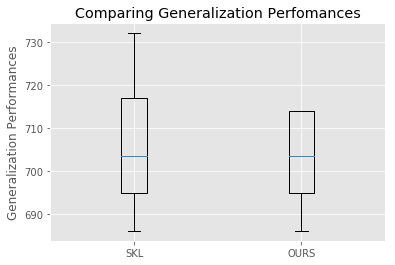

In [23]:
plt.boxplot([sk_performances,custom_performances])
plt.title("Comparing Generalization Perfomances")
plt.xlabel('')
plt.ylabel('Generalization Performances')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


We see here that both implementations score similar values based on our scorer method.

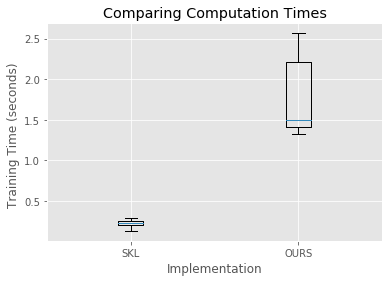

In [24]:
plt.boxplot([sk_times,custom_times])
plt.title("Comparing Computation Times")
plt.xlabel('Implementation')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

Despite our performance scores being similar, SKL is much faster than our custom implementation.

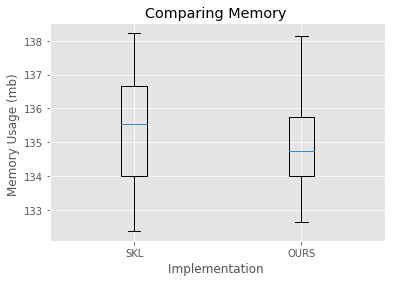

In [25]:
plt.boxplot([sk_mem,custom_mem])
plt.title("Comparing Memory ")
plt.xlabel('Implementation ')
plt.ylabel('Memory Usage (mb) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

It looks like both implementations use similar amounts of memory, with SKL using a wider range. But there really isn't a clearly superior implementation.